Simulating image data for 10 classes...
Data shape: (32, 32, 3), Number of Classes: 10

Building CNN model...
Training the model (using mock data)...
Training complete.

Evaluating model performance...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

--- Classification Report (Precision, Recall, F1 Score) ---
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         6
     Class 1       0.14      1.00      0.25        14
     Class 2       0.00      0.00      0.00        12
     Class 3       0.00      0.00      0.00        11
     Class 4       0.00      0.00      0.00         8
     Class 5       0.00      0.00      0.00        10
     Class 6       0.00      0.00      0.00         6
     Class 7       0.00      0.00      0.00        13
     Class 8       0.00      0.00      0.00         9
     Class 9       0.00      0.00      0.00        11

    accuracy                           0.14       100
   macro avg       0.01      0.10      0.02      

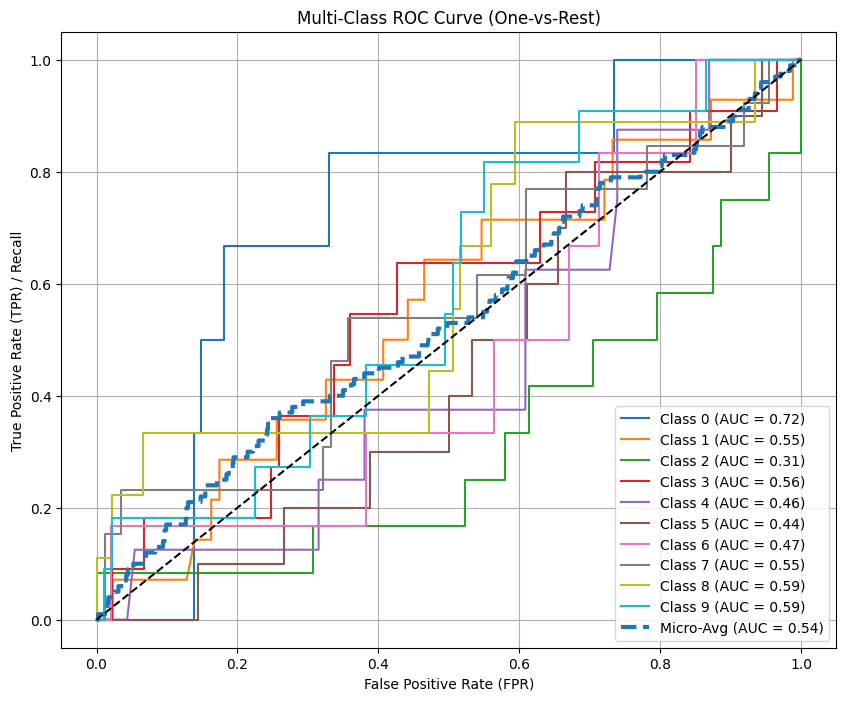


Average AUC (Micro-Averaged): 0.5374
Individual Class AUC Scores:
  Class 0: 0.7216
  Class 1: 0.5536
  Class 2: 0.3134
  Class 3: 0.5577
  Class 4: 0.4620
  Class 5: 0.4389
  Class 6: 0.4663
  Class 7: 0.5526
  Class 8: 0.5922
  Class 9: 0.5853

Plotting Macro Precision-Recall Curve...


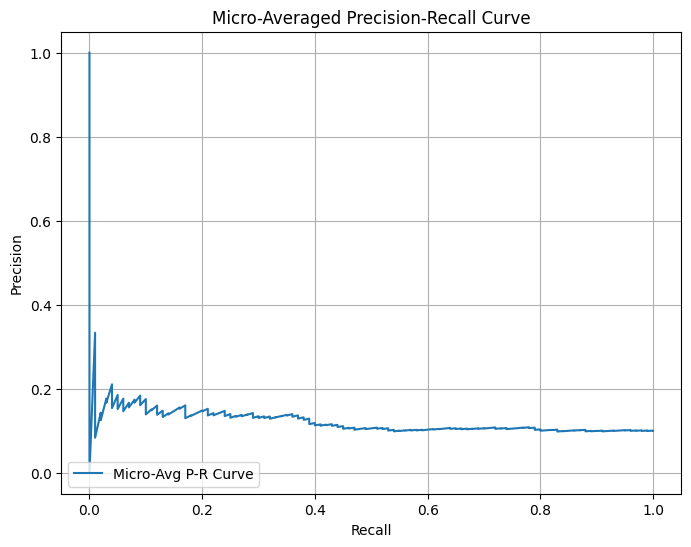

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, f1_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# --- 1. Data Simulation (Using Mock CIFAR-10 structure) ---
# In a real Colab notebook, you would load data like:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
def load_mock_data(num_samples=500, img_size=(32, 32, 3), num_classes=10):
    print("Simulating image data for 10 classes...")
    x_data = np.random.rand(num_samples, *img_size).astype('float32')
    y_data = np.random.randint(0, num_classes, num_samples)
    # Simple preprocessing
    x_data /= 255.0
    y_data_one_hot = to_categorical(y_data, num_classes=num_classes)
    return x_data[:400], y_data_one_hot[:400], x_data[400:], y_data[400:], y_data_one_hot[400:]

X_train, Y_train_one_hot, X_test, Y_test_labels, Y_test_one_hot = load_mock_data()
IMG_SHAPE = X_train.shape[1:]
NUM_CLASSES = Y_train_one_hot.shape[1]
CLASS_NAMES = [f'Class {i}' for i in range(NUM_CLASSES)]
print(f"Data shape: {IMG_SHAPE}, Number of Classes: {NUM_CLASSES}")

# --- 2. Build the CNN Model ---
print("\nBuilding CNN model...")
# [Image of Convolutional Neural Network architecture]
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SHAPE, padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

# --- 3. Compile and Train ---
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train with simulated data (epochs kept low for quick run)
print("Training the model (using mock data)...")
history = model.fit(X_train, Y_train_one_hot, epochs=5, batch_size=32, verbose=0, validation_split=0.1)
print("Training complete.")

# --- 4. Prediction and Evaluation Metrics ---
print("\nEvaluating model performance...")
Y_pred_probs = model.predict(X_test)
Y_pred_labels = np.argmax(Y_pred_probs, axis=1)

# A. Classification Report (Precision, Recall, F1 Score)
print("\n--- Classification Report (Precision, Recall, F1 Score) ---")
print(classification_report(Y_test_labels, Y_pred_labels, target_names=CLASS_NAMES, zero_division=0))

# B. Macro-averaged F1 Score
macro_f1 = f1_score(Y_test_labels, Y_pred_labels, average='macro', zero_division=0)
print(f"Macro-Averaged F1 Score: {macro_f1:.4f}")

# C. ROC Curve and AUC Calculation (One-vs-Rest)
#
print("\n--- ROC Curve and AUC (One-vs-Rest) ---")
binarizer = LabelBinarizer()
Y_test_binary = binarizer.fit_transform(Y_test_labels)

plt.figure(figsize=(10, 8))
roc_auc_scores = {}

for i in range(NUM_CLASSES):
    # Calculate ROC curve and AUC for each class (One-vs-Rest)
    fpr, tpr, _ = roc_curve(Y_test_binary[:, i], Y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores[CLASS_NAMES[i]] = roc_auc
    plt.plot(fpr, tpr, label=f'{CLASS_NAMES[i]} (AUC = {roc_auc:.2f})')

# Calculate Micro-Averaged ROC Curve and AUC (often preferred for multi-class)
fpr_micro, tpr_micro, _ = roc_curve(Y_test_binary.ravel(), Y_pred_probs.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

plt.plot(fpr_micro, tpr_micro, label=f'Micro-Avg (AUC = {auc_micro:.2f})', linestyle='--', linewidth=3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Multi-Class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"\nAverage AUC (Micro-Averaged): {auc_micro:.4f}")
print("Individual Class AUC Scores:")
for name, score in roc_auc_scores.items():
    print(f"  {name}: {score:.4f}")

# D. Precision-Recall Curve (for context, although not explicitly requested, it complements the others)
print("\nPlotting Macro Precision-Recall Curve...")
plt.figure(figsize=(8, 6))
# Calculate Macro Precision-Recall
P_macro, R_macro, _ = precision_recall_curve(Y_test_binary.ravel(), Y_pred_probs.ravel())
plt.plot(R_macro, P_macro, label='Micro-Avg P-R Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-Averaged Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 91s 57ms/step - accuracy: 0.4131 - loss: 1.6219
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 90s 58ms/step - accuracy: 0.6288 - loss: 1.0549
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 90s 58ms/step - accuracy: 0.6931 - loss: 0.8927
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 88s 56ms/step - accuracy: 0.7281 - loss: 0.7777
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 88s 56ms/step - accuracy: 0.7557 - loss: 0.6955
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
              precision    recall  f1-score   support

           0       0.71      0.76      0.73      1000
           1       0.83      0.80      0.82      1000
           2       0.65      0.56      0.60      1000
           3       0.54      0.53      0.53      1000
           4       0.65      0.67      0.66      1000
           5       0.63      0.63      0.63      1000
           6       0.77      0.77      0.77      1000
           7       0.82      0.74      0.78      1000
           8       0.76   

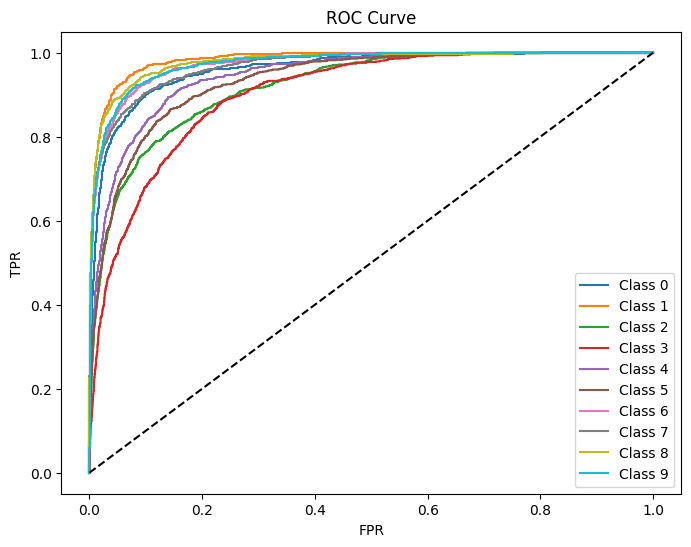

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, roc_curve
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# -------------------- Load & Preprocess --------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)

# -------------------- Build Model --------------------
model = Sequential([
    Input(shape=(32, 32, 3)),                 # <--- solves warning
    Conv2D(32, 3, activation='relu', padding='same'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# -------------------- Train --------------------
model.fit(x_train, y_train_cat, epochs=5, batch_size=32, verbose=1)



# -------------------- Predict & Evaluate --------------------
# Get prediction probabilities for test set
y_prob = model.predict(x_test)

# Convert probability vectors to class labels (0–9)
y_pred = np.argmax(y_prob, axis=1)

# Print precision, recall, F1-score for each class
print(classification_report(y_test, y_pred))


# -------------------- ROC Curve for All Classes --------------------
# Binarize test labels so ROC can be plotted for each class
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

plt.figure(figsize=(8, 6))

# Plot ROC curve for each class separately
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {i}')

# Diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('FPR')      # False Positive Rate
plt.ylabel('TPR')      # True Positive Rate
plt.title('ROC Curve') # ROC Curve for all CIFAR-10 classes
plt.legend()
